In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
def trainKNN(df, k):
    X = df[['feature1','feature2']]
    y = df['class']
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    return clf, df, k

In [3]:
def plotROC(clf, df, k, plot=True):
    scores = clf.predict_proba(df[['feature1','feature2']])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(df['class'], scores)
    P_H1 = len(df[df['class']==1])/len(df)
    P_H0 = len(df[df['class']==0])/len(df)
    P_cd = P_H1 * tpr + P_H0 * (1 - fpr)
    P_cd_max = P_cd.max()
    P_cd_idxmax = np.argmax(P_cd)
    plt.figure(dpi=150)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr[P_cd_idxmax], tpr[P_cd_idxmax], marker='s',label='max $P_{cd}$=%.3f' %P_cd_max)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('$P_{FA}$')
    plt.ylabel('$P_D$')
    plt.legend(loc="lower right")
    plt.title('Receiver Operating Characteristic (k = %i)'% k)
    if plot:
        plt.show()
    else:
        plt.close()
    P_cd_min = 1 - P_cd_max
    return P_cd_min

In [4]:
train_df = pd.read_csv("dataSetHorseshoes.csv", names=['class','feature1','feature2'])
test_df = pd.read_csv("dataSetHorseshoesTest.csv", names=['class','feature1','feature2'])

In [8]:
P_e_cross = np.zeros(180)
key = np.arange(1,11)
key = np.repeat(key,40)
np.random.shuffle(key)
train_df['fold'] = key
for i in range(1,360,2):   #specify k
    scores_ave = np.zeros(400)
    class_ave = np.zeros(400)
    for j in range(1,11):   #specify fold
        X_train = train_df[train_df['fold']!=j][['feature1','feature2']]
        y_train = train_df[train_df['fold']!=j]['class']
        X_test = train_df[train_df['fold']==j][['feature1','feature2']]
        y_test = train_df[train_df['fold']==j]['class']
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X_train,y_train)
        scores_ave[(j-1)*40:j*40] = clf.predict_proba(X_test)[:,1]
        class_ave[(j-1)*40:j*40] = y_test
    fpr, tpr, thresholds = metrics.roc_curve(class_ave, scores_ave)
    P_H1 = (class_ave==1).sum()/len(class_ave)
    P_H0 = (class_ave==0).sum()/len(class_ave)
    P_cd = P_H1 * tpr + P_H0 * (1 - fpr)
    P_cd_max = P_cd.max()
    P_e_cross[int((i-1)/2)] = 1 - P_cd_max
cross_min = P_e_cross.min()
min_index = P_e_cross.argmin()
k_ideal = min_index * 2 + 1

In [9]:
P_e_list = np.zeros(200)
P_e_list2 = np.zeros(200)
for i in range(1,400,2):
    clf, df, k = trainKNN(train_df, i)
    P_e = plotROC(clf, df, k, plot=False)
    P_e_list[int((i-1)/2)] = P_e
for i in range(1,400,2):
    clf, df, k = trainKNN(train_df, i)
    P_e = plotROC(clf, test_df, k, plot=False)
    P_e_list2[int((i-1)/2)] = P_e
x = np.arange(1,400,2)
x = 400 / x
'''
test_min = P_e_list2.min()
min_index = P_e_list2.argmin()
k_ideal = min_index * 2 + 1
'''
x2 = np.arange(1,360,2)
x2 = 400 / x2

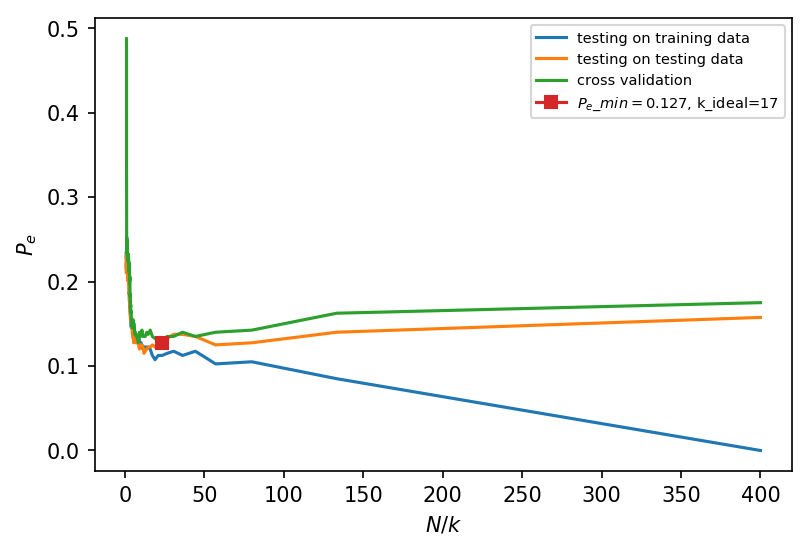

In [10]:
plt.figure(dpi=150)
plt.xlabel('$N/k$')
plt.ylabel('$P_e$')
plt.plot(x, P_e_list, label='testing on training data')
plt.plot(x, P_e_list2, label='testing on testing data')
plt.plot(x2, P_e_cross, label='cross validation')
plt.plot(400/k_ideal, cross_min, marker='s', label='$P_e\_min=%.3f$, k_ideal=%d' %(cross_min, k_ideal))
plt.legend(loc="upper right",prop={'size': 7})
plt.show()